In [2]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [2]:
df = pd.read_excel('../data/Becker_promoter/1-s2.0-S1525001625003016-mmc2.xlsx')
df = df.iloc[1:, 1:]
df.columns = df.iloc[0]
df = df.iloc[1:, :].reset_index(drop=True)
df = df.rename(columns={'sequence': 'seq'})
df

1,Promoter name,Description,Supposed specificity,Origin (viral/mammalian/synthetic/chimeric),seq,Total size of promoter (bp),Reference (PubMed ID),Size of LacZ stuffer (bp),Final size of the construct
0,AAT,Promoter of Homo sapiens serpin family A membe...,liver,mammalian,gatcttgctaccagtggaacagccactaaggattctgcagtgagag...,397,10933977,2000,3923
1,AAT short,Short version of hAAT promoter,liver,mammalian,aatgactcctttcggtaagtgcagtggaagctgtacactgcccagg...,251,10933977,2200,3977
2,ADIPOQ,"Human Adiponectin, C1Q and collagen domain con...",fat,mammalian,gcccttcaaaaacaaaacatgagcgtgccaagaaagtccaaggtgt...,1077,15850785; 18931025,1500,4103
3,Albumin,Mus musculus albumin (Alb) 5' regulatory regio...,liver,mammalian,ggcatgcttccatgccaaggcccacactgaaatgctcaaatgggag...,335,2722822,2200,4061
4,AP2.2,Promoter region of Mus musculus adiponectin (r...,fat,mammalian,aaaccacccagcaaaaaaccaaaccgcctagcctcaagacatgtgt...,2274,18760339; 25551639,no LacZ,3800
...,...,...,...,...,...,...,...,...,...
53,TnT,"Promoter of Homo sapiens troponin T2, cardiac ...",heart,mammalian,ctcagtccattaggagccagtagcctggaagatgtctttaccccca...,544,25082846,2000,4070
54,TTR,Enhancer + promoter region of Mus musculus tra...,liver,mammalian,ggatctgtcaattcacgcgagttaataattaccagcgcgggccaaa...,541,1690125,2000,4067
55,UBC,Promoter of Homo sapiens ubiquitin C (UBC) (re...,ubiquitous,mammalian,ggtgcagcggcctccgcgccgggttttggcgcctcccgcgggcgcc...,1258,11704814,1200,3984
56,UCP1,Mus musculus uncoupling protein 1 (Ucp) distal...,mitochondria/brown adipose tissue,mammalian,cgtcacagagggtcagtcacccttgaccacactgaactagtcgtca...,527,28930673; 8264627,2000,4053


In [3]:
df.to_csv('../data/Becker_promoter/Becker_promoter_long.tsv', sep='\t', index=False)

In [ ]:
from MPRA_predict import models, datasets, metrics, utils
from MPRA_predict.utils import *

data_path = '../data/Becker_promoter/Becker_promoter_long.tsv'
device = 'cuda:1'
output_path = 'outputs/Becker_promoter_long_Sei_pred.h5'

In [ ]:
@torch.no_grad()
def get_pred(model, test_data_loader, device='cuda', writer: HDF5Writer=None, flush_every=16):
    model = model.to(device)
    y_pred = []
    model.eval()
    for i, batch in enumerate(tqdm(test_data_loader)):
        if isinstance(batch, (list, tuple)):
            x = batch[0]
        elif isinstance(batch, dict):
            x = batch['seq']
        else:
            x = batch
        x = x.to(device)
        output = model(x)

        output = output.detach().cpu().numpy()
        writer.append(output)
        if (i+1) % flush_every == 0:
            writer.flush()
    writer.flush()
    writer.close()




model_path = f'../data/Sei/resources/sei.pth'
model_state_dict = torch.load(model_path)
model_state_dict = {k.replace('module.model.', ''): v for k, v in model_state_dict.items()}
model = models.Sei()
model.load_state_dict(model_state_dict, strict=False)
model = model.to(device)

dataset = datasets.SeqDataset(
    data_path=data_path,
    seq_column='seq', 

    crop=False,
    # crop=True,
    # cropped_length=200,
    padding=True,
    padding_method='N',
    padded_length=4096,
    N_fill_value=0.25,
)

test_data_loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
writer = HDF5Writer(output_path)
pred = get_pred(model, test_data_loader, device, writer)

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


In [3]:
model_info_df = pd.read_csv('../data/Sei/Sei_tracks_info.csv')

df_pivot = model_info_df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)
df_pivot = df_pivot.map(lambda x: x if isinstance(x, list) else [])

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
df_track = df_pivot.loc[df_pivot[assays].map(len).gt(0).all(axis=1),assays]
df_track.map(len)

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
A549,4,45,53,10
AG04450_Fibroblast_Fetal_Lung,2,1,1,3
Astrocyte_Brain,3,1,1,1
BE2-C,3,3,5,3
BJ_Fibroblast_Foreskin,8,5,3,3
...,...,...,...,...
Rh4_rhabdomyosarcoma,3,1,1,2
Sigmoid_Colon,2,3,3,2
Stomach,4,14,12,3


In [14]:
cell_types = list(df_track.index)
print(repr(cell_types))

['A549', 'AG04450_Fibroblast_Fetal_Lung', 'Astrocyte_Brain', 'BE2-C', 'BJ_Fibroblast_Foreskin', 'B_Lymphocyte_Blood', 'Brain', 'Caco-2_Epithelium_Colon', 'Embryonic_Stem_Cell_Embryo', 'Endothelial_Cell_Umbilical_Vein', 'Epithelium', 'Epithelium_Lung', 'Epithelium_Mammary_Gland', 'Fibroblast', 'GM06990_B_Lymphocyte_Blood', 'GM12878_B_Lymphocyte_Blood', 'GM12891_Lymphoblastoid_Blood', 'GM12892_Lymphoblastoid_Blood', 'GM18486_Lymphoblastoid_Blood', 'GM18505_Lymphoblastoid_Blood', 'GM19099_Lymphoblastoid_Blood', 'GM19193_Lymphoblastoid_Blood', 'GM19238_Lymphoblastoid_Blood', 'GM19239_Lymphoblastoid_Blood', 'GM19240_Lymphoblastoid_Blood', 'H1-hESC', 'H1_Embryonic_Stem_Cell_Embryo', 'HCT-116_Colorectal_cancer_cell_line', 'HL-60_Leukemia_Cell', 'HMEC_Mammary_Epithelial', 'HSMM_Skeletal_Muscle_Myoblasts', 'HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM', 'HUVEC_Umbilical_Vein_Endothelial_Cells', 'HeLa-S3_Epithelium_Cervix', 'HeLa_Cervical_Carcinoma', 'HepG2_Hepatocellular_Carcinoma', 'IMR

In [4]:
pred_array = load_h5('outputs/Becker_promoter_long_Sei_pred.h5')
pred_array.shape

file outputs/Becker_promoter_long_Sei_pred.h5 has keys: ['data']


(58, 21907)

In [5]:
ref_pred_array = load_h5('outputs/Gosai_MPRA_Sei_pred.h5')
print(ref_pred_array.shape)

file outputs/Gosai_MPRA_Sei_pred.h5 has keys: ['data']
(760679, 21907)


In [6]:
ref_mean = np.mean(logit(ref_pred_array[:10000]), axis=0)

In [7]:
cell_types = list(df_track.index)

In [8]:
VEF_dict = {}
for cell_type in cell_types:
    for assay in assays:
        indice = df_track.loc[cell_type, assay]
        key = f'{cell_type}_{assay}'
        if isinstance(indice, list) and len(indice) > 0:
            pred = logit(pred_array[:, indice]).mean(1)
            ref_pred = ref_mean[indice].mean(0)
            VEF_dict[key] = pred - ref_pred
        else:
            VEF_dict[key] = np.full(pred_array.shape[0], np.nan)

VEF_df = pd.DataFrame(VEF_dict)
VEF_df.describe()

,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF,AG04450_Fibroblast_Fetal_Lung_DNase,AG04450_Fibroblast_Fetal_Lung_H3K4me3,AG04450_Fibroblast_Fetal_Lung_H3K27ac,AG04450_Fibroblast_Fetal_Lung_CTCF,Astrocyte_Brain_DNase,Astrocyte_Brain_H3K4me3,Astrocyte_Brain_H3K27ac,Astrocyte_Brain_CTCF,BE2-C_DNase,BE2-C_H3K4me3,BE2-C_H3K27ac,BE2-C_CTCF,BJ_Fibroblast_Foreskin_DNase,BJ_Fibroblast_Foreskin_H3K4me3,BJ_Fibroblast_Foreskin_H3K27ac,BJ_Fibroblast_Foreskin_CTCF,B_Lymphocyte_Blood_DNase,B_Lymphocyte_Blood_H3K4me3,B_Lymphocyte_Blood_H3K27ac,B_Lymphocyte_Blood_CTCF,Brain_DNase,Brain_H3K4me3,Brain_H3K27ac,Brain_CTCF,Caco-2_Epithelium_Colon_DNase,Caco-2_Epithelium_Colon_H3K4me3,Caco-2_Epithelium_Colon_H3K27ac,Caco-2_Epithelium_Colon_CTCF,Embryonic_Stem_Cell_Embryo_DNase,Embryonic_Stem_Cell_Embryo_H3K4me3,Embryonic_Stem_Cell_Embryo_H3K27ac,Embryonic_Stem_Cell_Embryo_CTCF,Endothelial_Cell_Umbilical_Vein_DNase,Endothelial_Cell_Umbilical_Vein_H3K4me3,Endothelial_Cell_Umbilical_Vein_H3K27ac,Endothelial_Cell_Umbilical_Vein_CTCF,Epithelium_DNase,Epithelium_H3K4me3,Epithelium_H3K27ac,Epithelium_CTCF,Epithelium_Lung_DNase,Epithelium_Lung_H3K4me3,Epithelium_Lung_H3K27ac,Epithelium_Lung_CTCF,Epithelium_Mammary_Gland_DNase,Epithelium_Mammary_Gland_H3K4me3,Epithelium_Mammary_Gland_H3K27ac,Epithelium_Mammary_Gland_CTCF,Fibroblast_DNase,Fibroblast_H3K4me3,Fibroblast_H3K27ac,Fibroblast_CTCF,GM06990_B_Lymphocyte_Blood_DNase,GM06990_B_Lymphocyte_Blood_H3K4me3,GM06990_B_Lymphocyte_Blood_H3K27ac,GM06990_B_Lymphocyte_Blood_CTCF,GM12878_B_Lymphocyte_Blood_DNase,GM12878_B_Lymphocyte_Blood_H3K4me3,GM12878_B_Lymphocyte_Blood_H3K27ac,GM12878_B_Lymphocyte_Blood_CTCF,GM12891_Lymphoblastoid_Blood_DNase,GM12891_Lymphoblastoid_Blood_H3K4me3,GM12891_Lymphoblastoid_Blood_H3K27ac,GM12891_Lymphoblastoid_Blood_CTCF,GM12892_Lymphoblastoid_Blood_DNase,GM12892_Lymphoblastoid_Blood_H3K4me3,GM12892_Lymphoblastoid_Blood_H3K27ac,GM12892_Lymphoblastoid_Blood_CTCF,GM18486_Lymphoblastoid_Blood_DNase,GM18486_Lymphoblastoid_Blood_H3K4me3,GM18486_Lymphoblastoid_Blood_H3K27ac,GM18486_Lymphoblastoid_Blood_CTCF,GM18505_Lymphoblastoid_Blood_DNase,GM18505_Lymphoblastoid_Blood_H3K4me3,GM18505_Lymphoblastoid_Blood_H3K27ac,GM18505_Lymphoblastoid_Blood_CTCF,GM19099_Lymphoblastoid_Blood_DNase,GM19099_Lymphoblastoid_Blood_H3K4me3,GM19099_Lymphoblastoid_Blood_H3K27ac,GM19099_Lymphoblastoid_Blood_CTCF,GM19193_Lymphoblastoid_Blood_DNase,GM19193_Lymphoblastoid_Blood_H3K4me3,GM19193_Lymphoblastoid_Blood_H3K27ac,GM19193_Lymphoblastoid_Blood_CTCF,GM19238_Lymphoblastoid_Blood_DNase,GM19238_Lymphoblastoid_Blood_H3K4me3,GM19238_Lymphoblastoid_Blood_H3K27ac,GM19238_Lymphoblastoid_Blood_CTCF,GM19239_Lymphoblastoid_Blood_DNase,GM19239_Lymphoblastoid_Blood_H3K4me3,GM19239_Lymphoblastoid_Blood_H3K27ac,GM19239_Lymphoblastoid_Blood_CTCF,GM19240_Lymphoblastoid_Blood_DNase,GM19240_Lymphoblastoid_Blood_H3K4me3,GM19240_Lymphoblastoid_Blood_H3K27ac,GM19240_Lymphoblastoid_Blood_CTCF,H1-hESC_DNase,H1-hESC_H3K4me3,H1-hESC_H3K27ac,H1-hESC_CTCF,H1_Embryonic_Stem_Cell_Embryo_DNase,H1_Embryonic_Stem_Cell_Embryo_H3K4me3,H1_Embryonic_Stem_Cell_Embryo_H3K27ac,H1_Embryonic_Stem_Cell_Embryo_CTCF,HCT-116_Colorectal_cancer_cell_line_DNase,HCT-116_Colorectal_cancer_cell_line_H3K4me3,HCT-116_Colorectal_cancer_cell_line_H3K27ac,HCT-116_Colorectal_cancer_cell_line_CTCF,HL-60_Leukemia_Cell_DNase,HL-60_Leukemia_Cell_H3K4me3,HL-60_Leukemia_Cell_H3K27ac,HL-60_Leukemia_Cell_CTCF,HMEC_Mammary_Epithelial_DNase,HMEC_Mammary_Epithelial_H3K4me3,HMEC_Mammary_Epithelial_H3K27ac,HMEC_Mammary_Epithelial_CTCF,HSMM_Skeletal_Muscle_Myoblasts_DNase,HSMM_Skeletal_Muscle_Myoblasts_H3K4me3,HSMM_Skeletal_Muscle_Myoblasts_H3K27ac,HSMM_Skeletal_Muscle_Myoblasts_CTCF,HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM_DNase,HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM_H3K4me3,HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM_H3K27ac,HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM_CTCF,HUVEC_Umbilical_Vein_Endothelial_Cells_DNase,HUVEC_Umbilical_Vein_E

In [9]:
VEF_df.to_csv('../data/Becker_promoter/Becker_promoter_VEF_zscoreonGosai.tsv', sep='\t', index=False)

In [18]:
subprocess.run([
    'python', 'train_scripts/test_1110.py', 
    '-s', 'saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/', 
    '-c', 'configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_Becker.yaml',
    '-o', 'Becker_pred.npy',
    '--device', 'cuda:1'],
    cwd='..'
)

use new config: configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_Becker.yaml


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


CompletedProcess(args=['python', 'train_scripts/test_1110.py', '-s', 'saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/', '-c', 'configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_Becker.yaml', '-o', 'Becker_pred.npy', '--device', 'cuda:1'], returncode=0)

In [37]:
seq_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_long.tsv', sep='\t')
pred = np.load('../saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/Becker_pred.npy')
pred_cols = [f'{c}_pred' for c in cell_types]

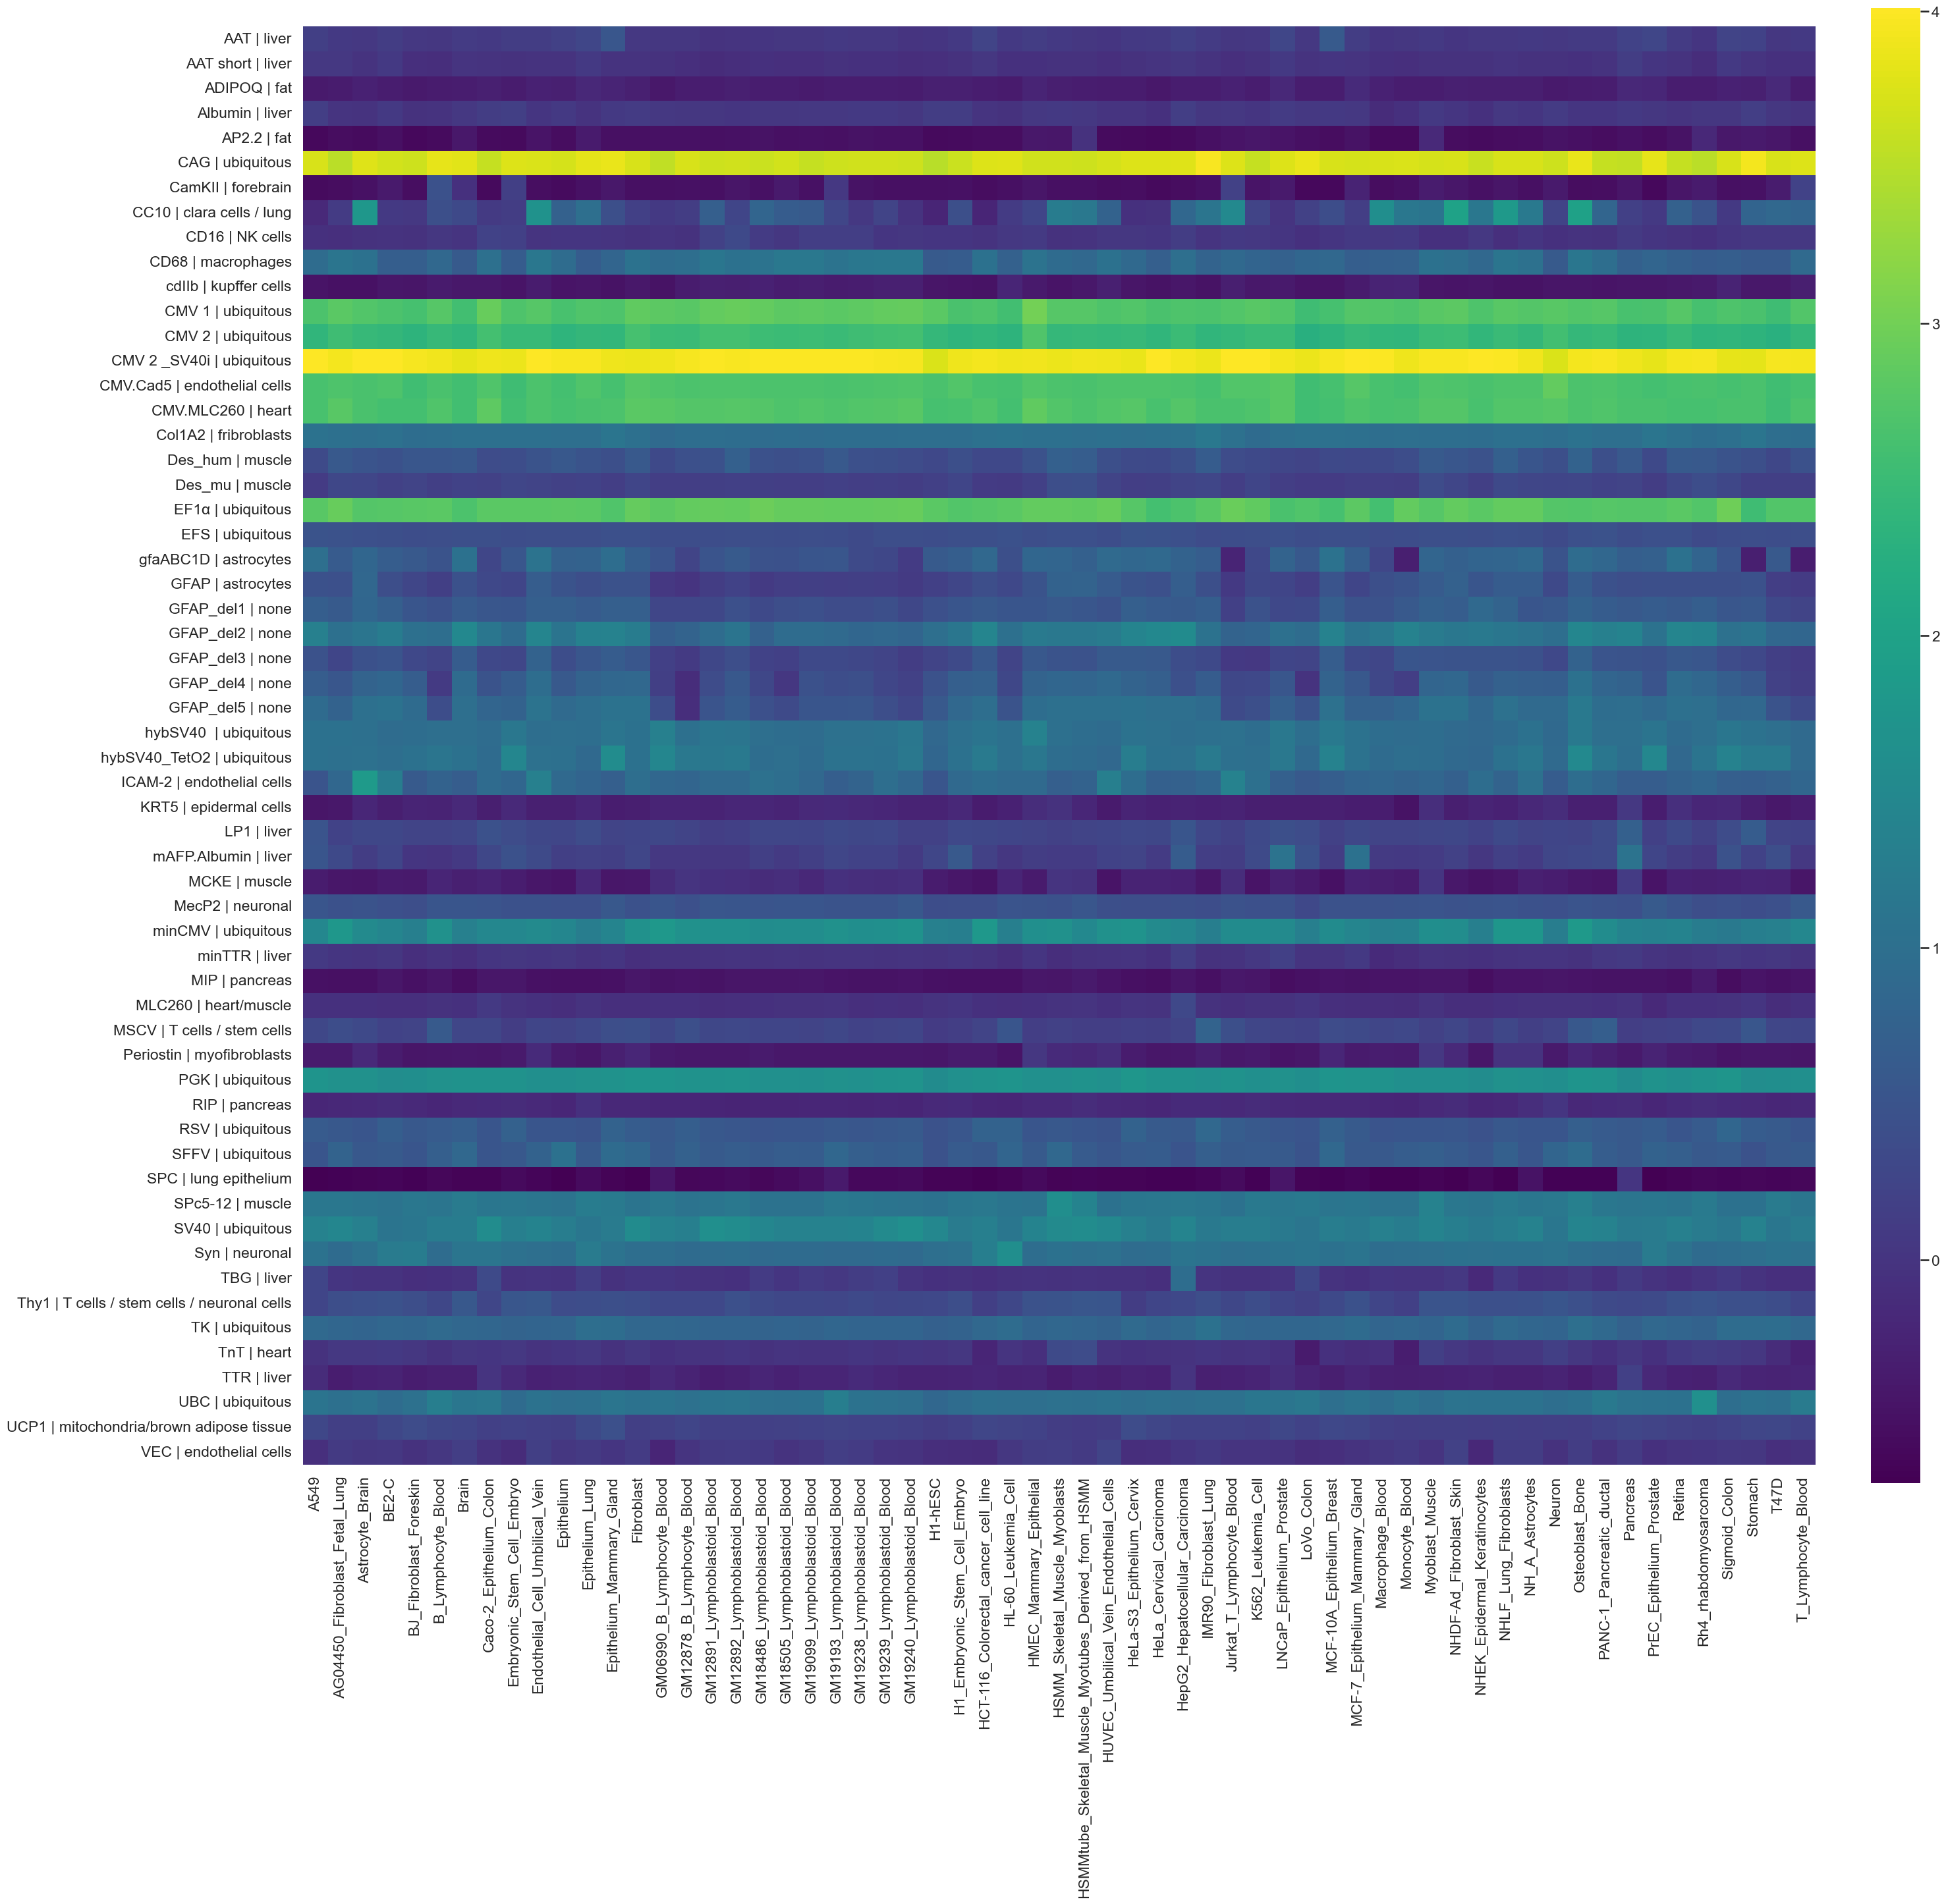

In [38]:
sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.heatmap(
    pred,
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

xticklabels = cell_types
ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
ax.set_xticklabels(xticklabels, rotation=90)


yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.savefig('figures/gene_therapy_prediction_heatmap.png', dpi=100)
plt.show()

In [39]:
# 每条序列 内部归一化
pred = (pred - pred.mean(axis=1, keepdims=True)) / pred.std(axis=1, keepdims=True)

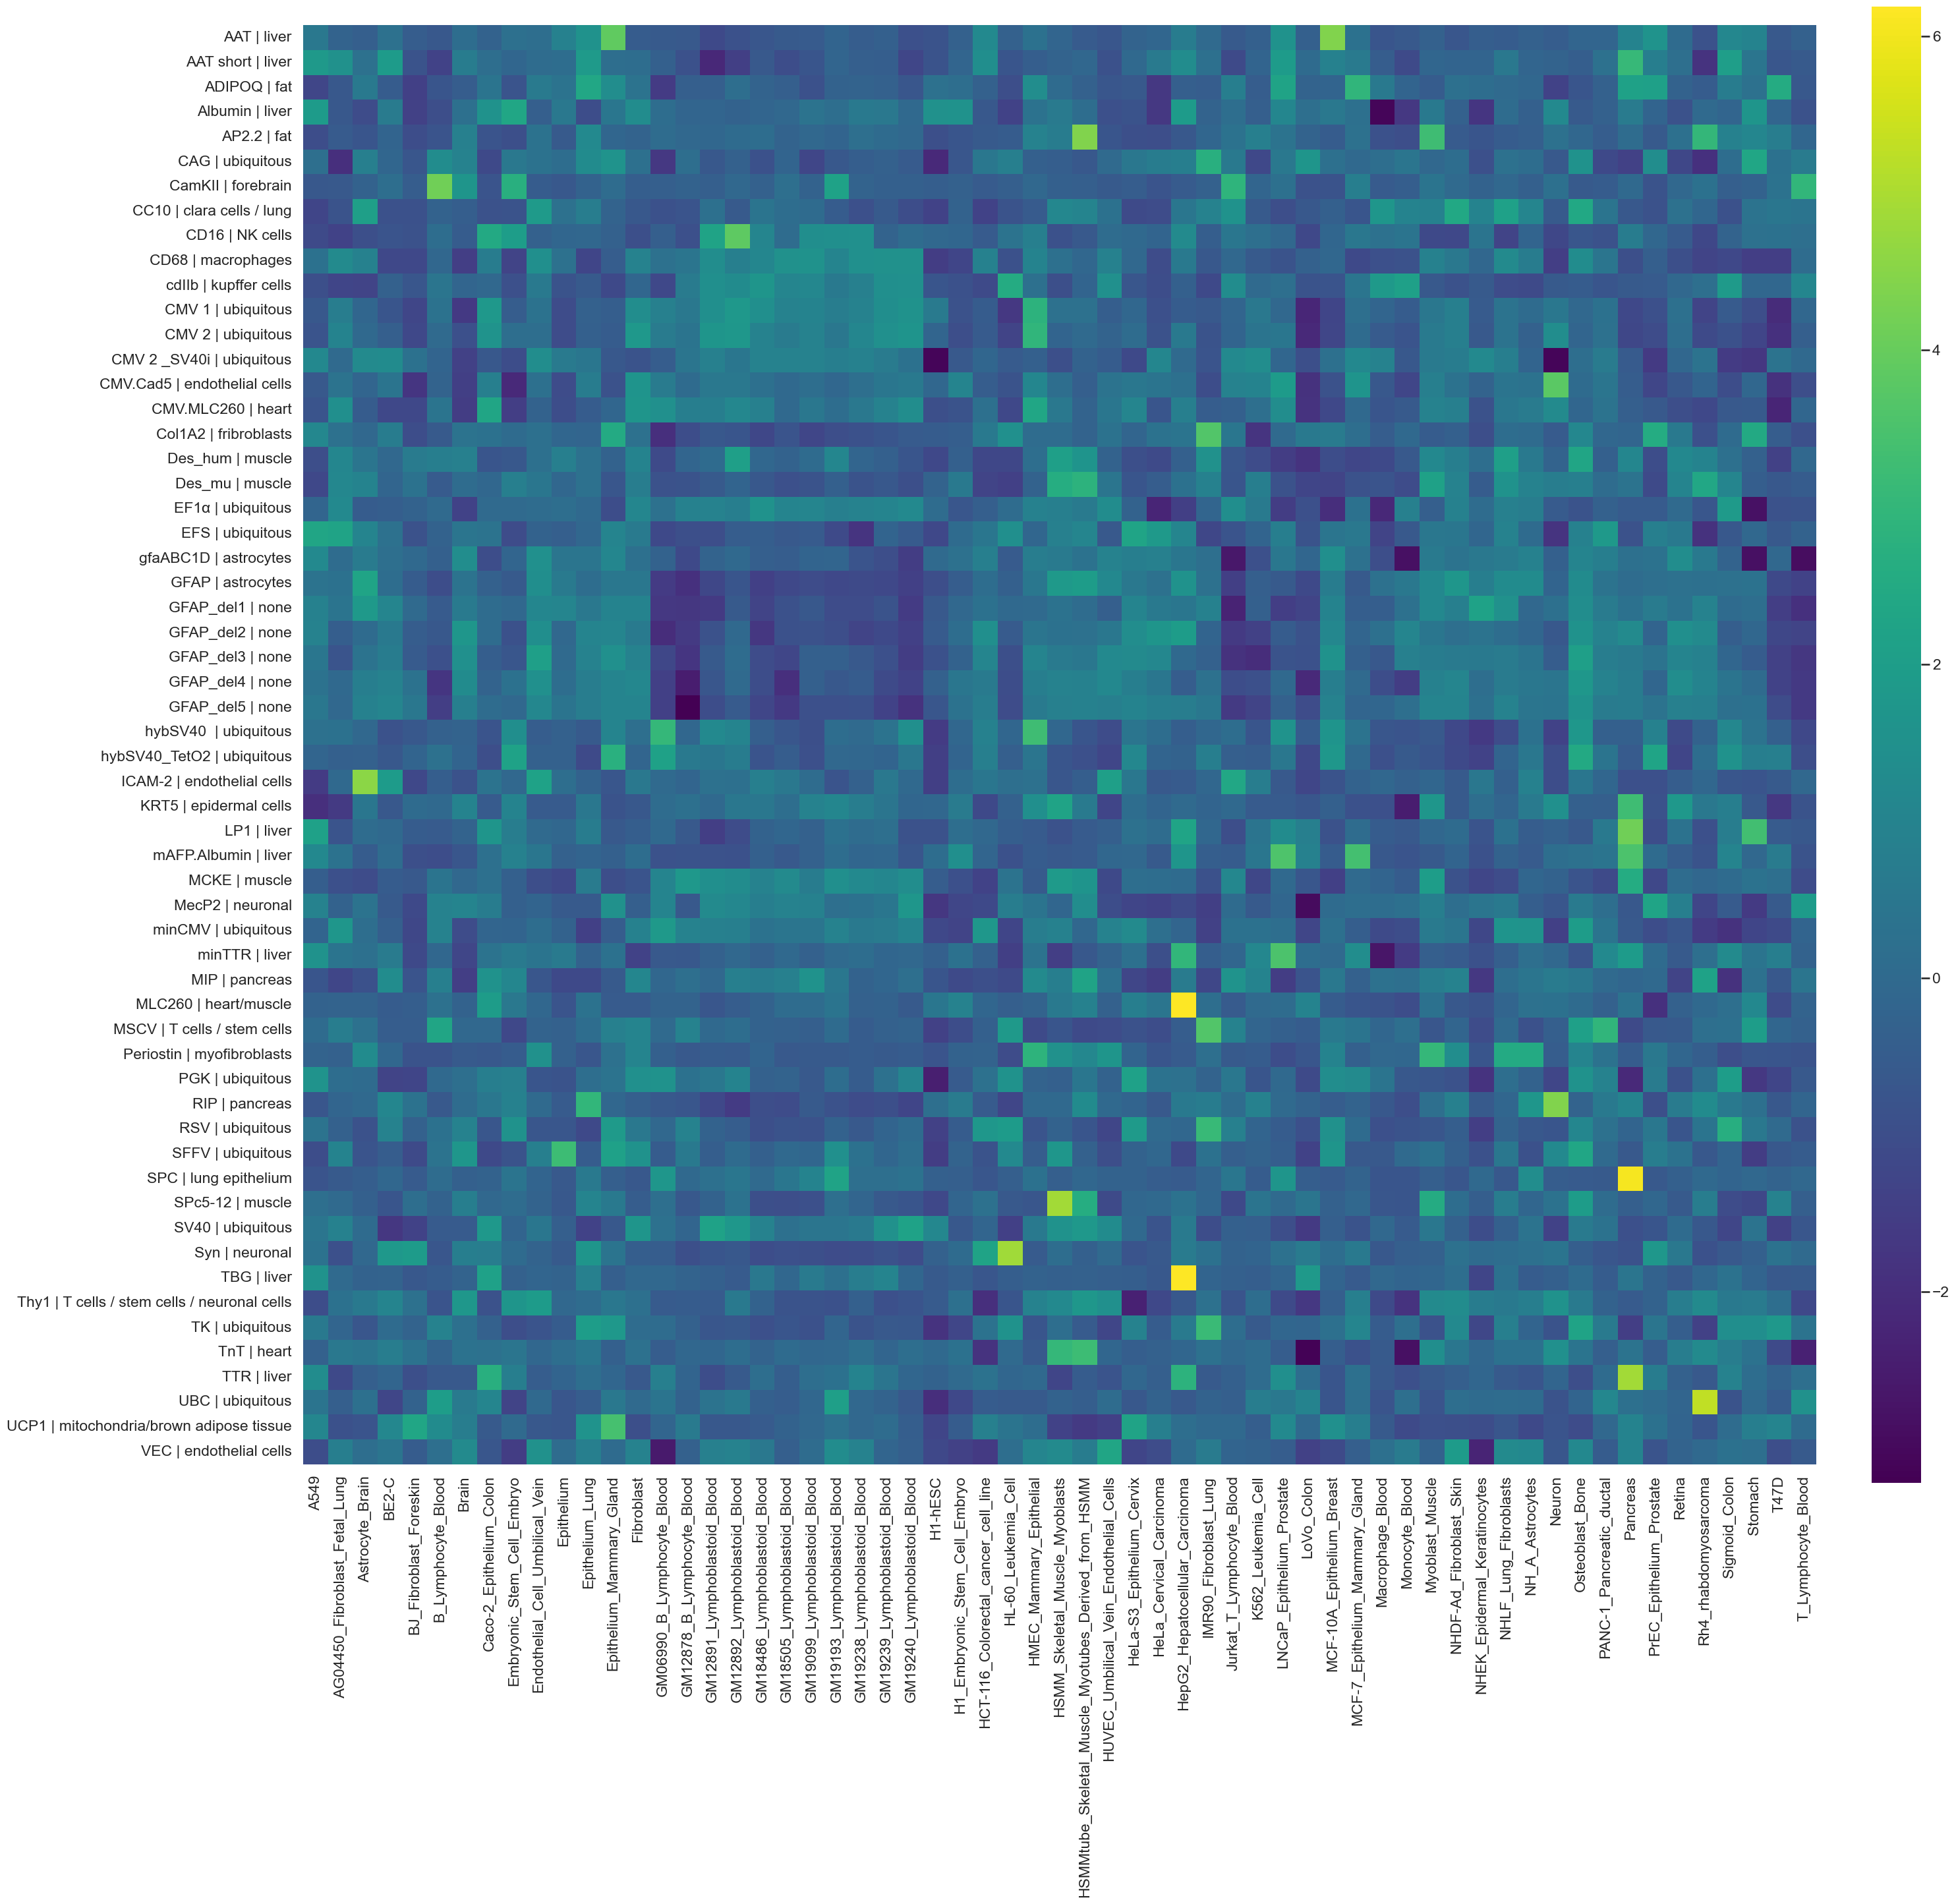

In [40]:
sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.heatmap(
    pred,
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

xticklabels = cell_types
ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
ax.set_xticklabels(xticklabels, rotation=90)


yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.savefig('figures/gene_therapy_prediction_heatmap.png', dpi=100)
plt.show()

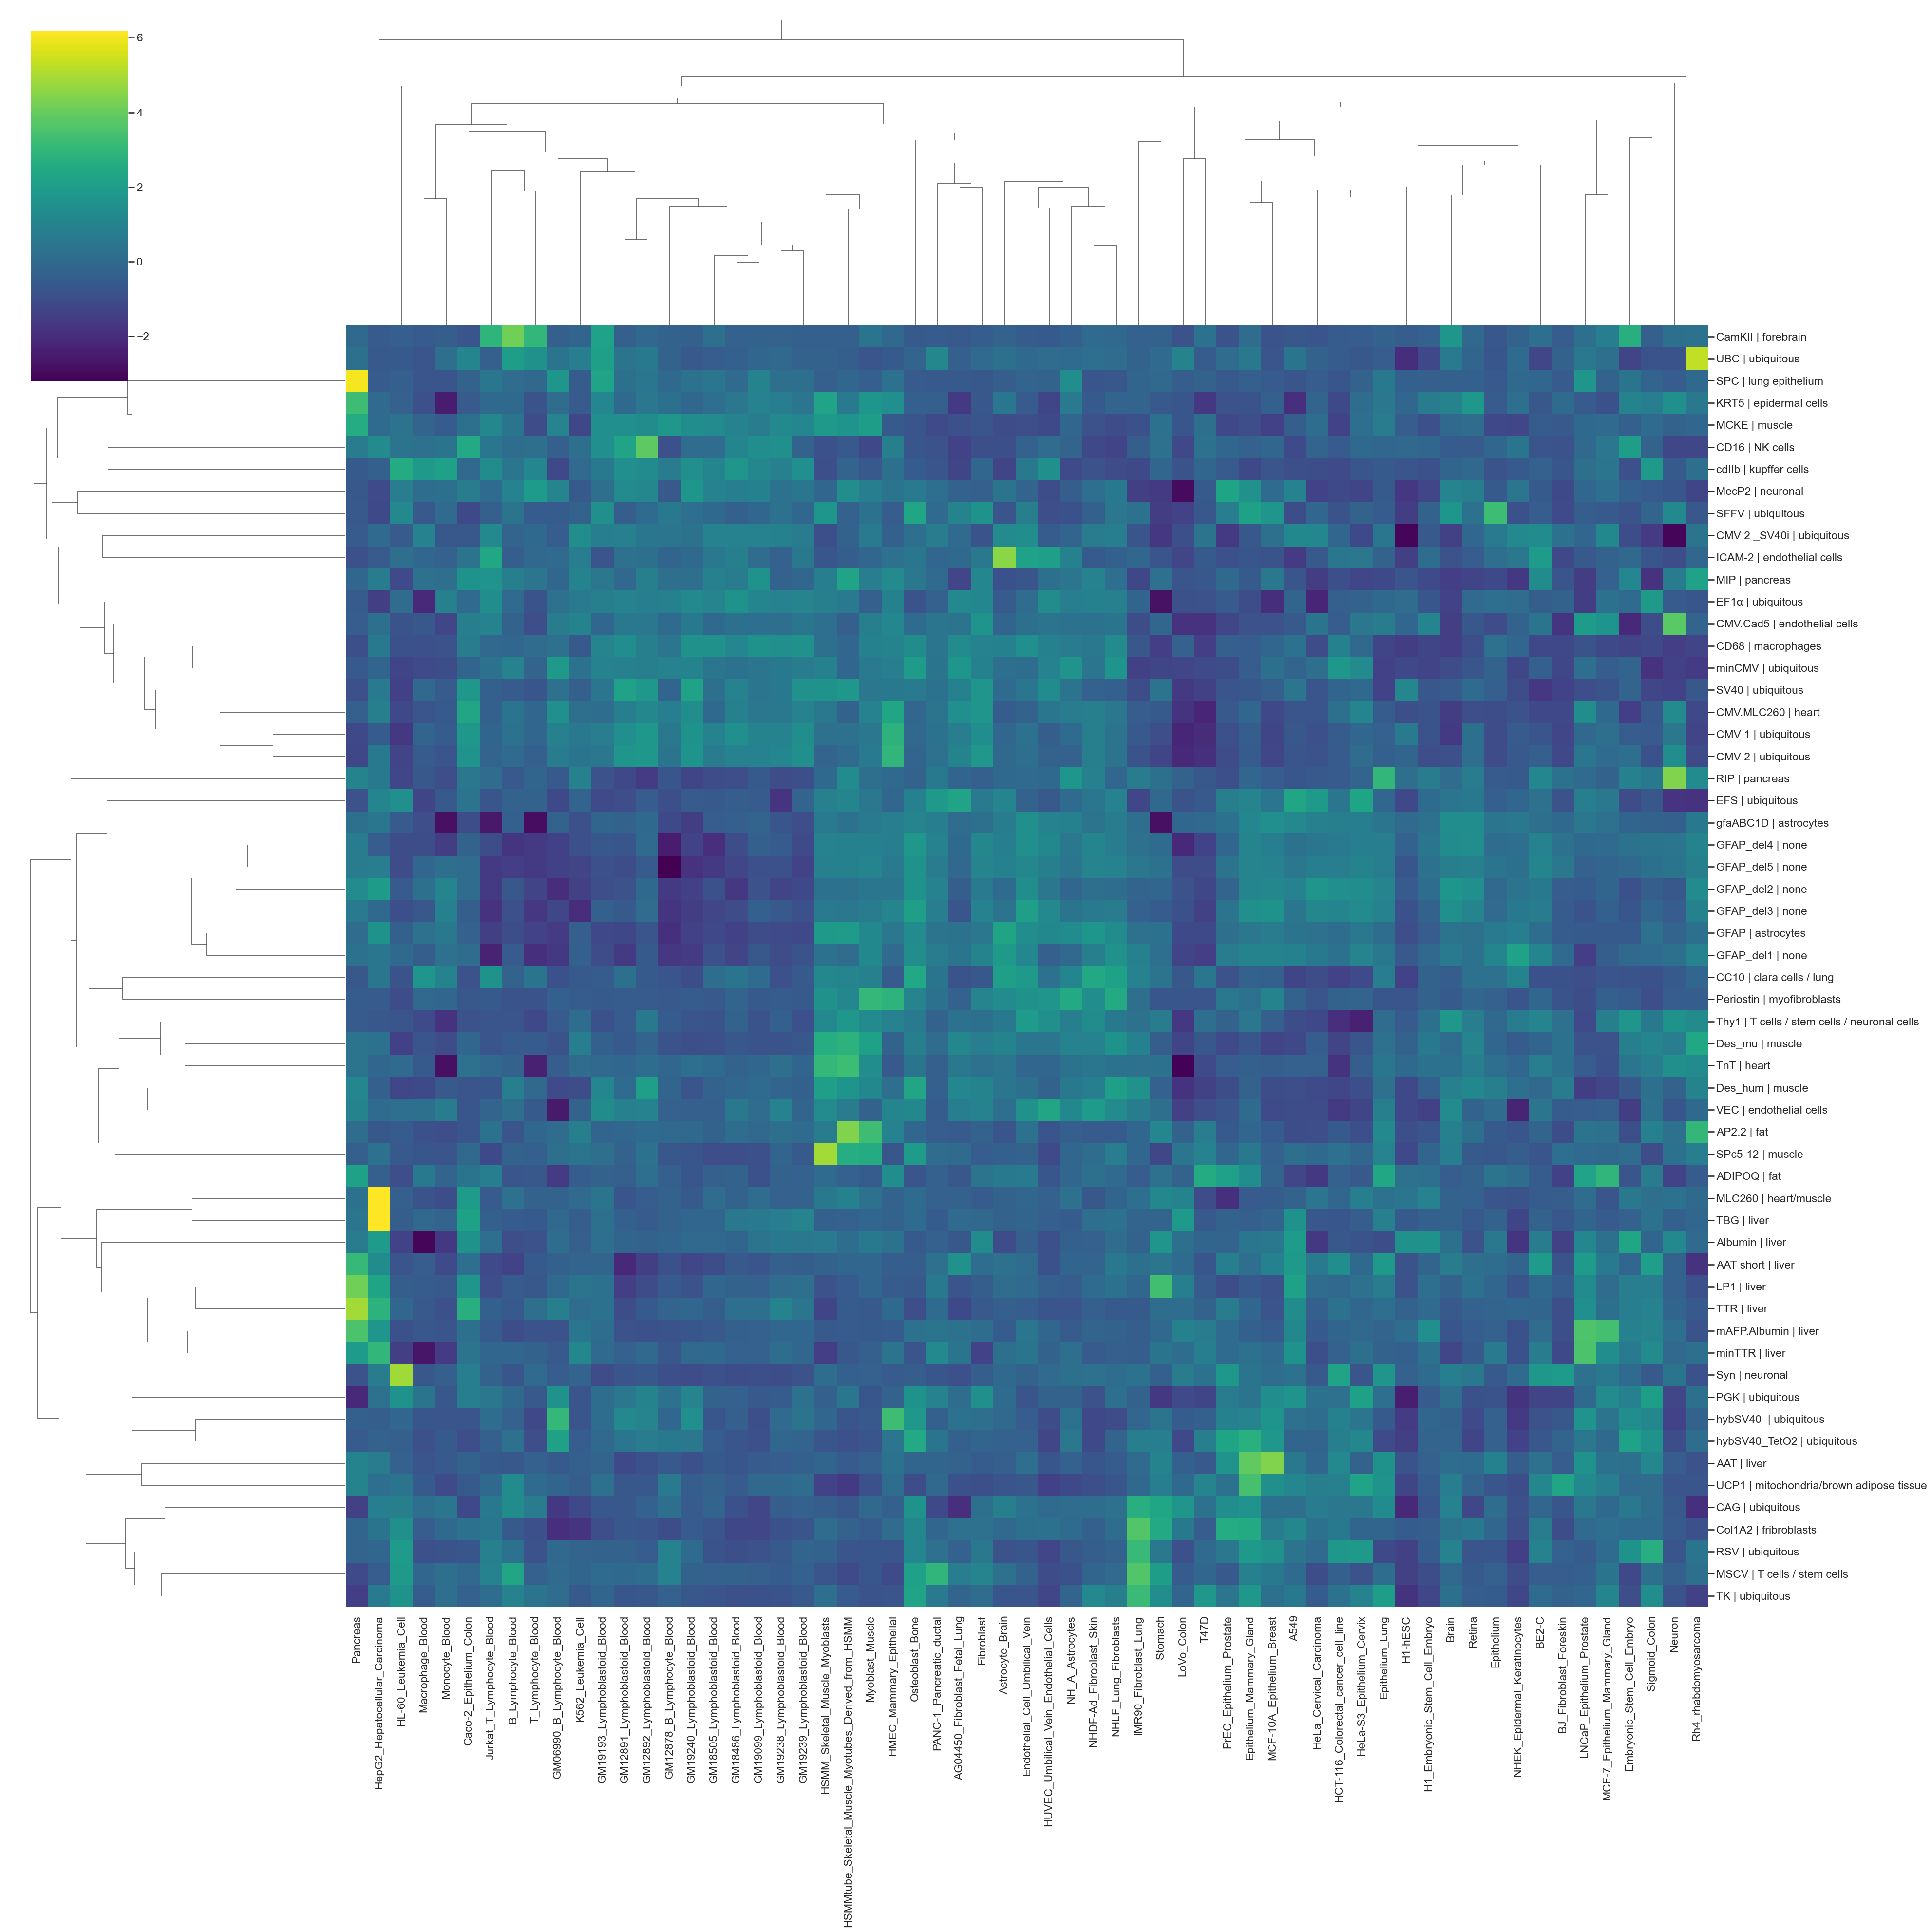

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 构建行名
yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)

# clustermap 自动做双向聚类 + 树状图
g = sns.clustermap(
    pred,
    method="average",    # 聚类方式
    metric="euclidean",  # 距离方式
    cmap="viridis",
    figsize=(40, 40),
    row_cluster=True,
    col_cluster=True,
    xticklabels=cell_types,
    yticklabels=yticklabels,
    cbar_kws={
        'shrink': 0.8,
        'aspect': 30,
        'pad': 0.03
    }
)

plt.savefig('figures/gene_therapy_prediction_clustermap.png', dpi=100)
plt.show()


In [42]:
seq_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_long.tsv', sep='\t')
VEF_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_VEF.tsv', sep='\t')


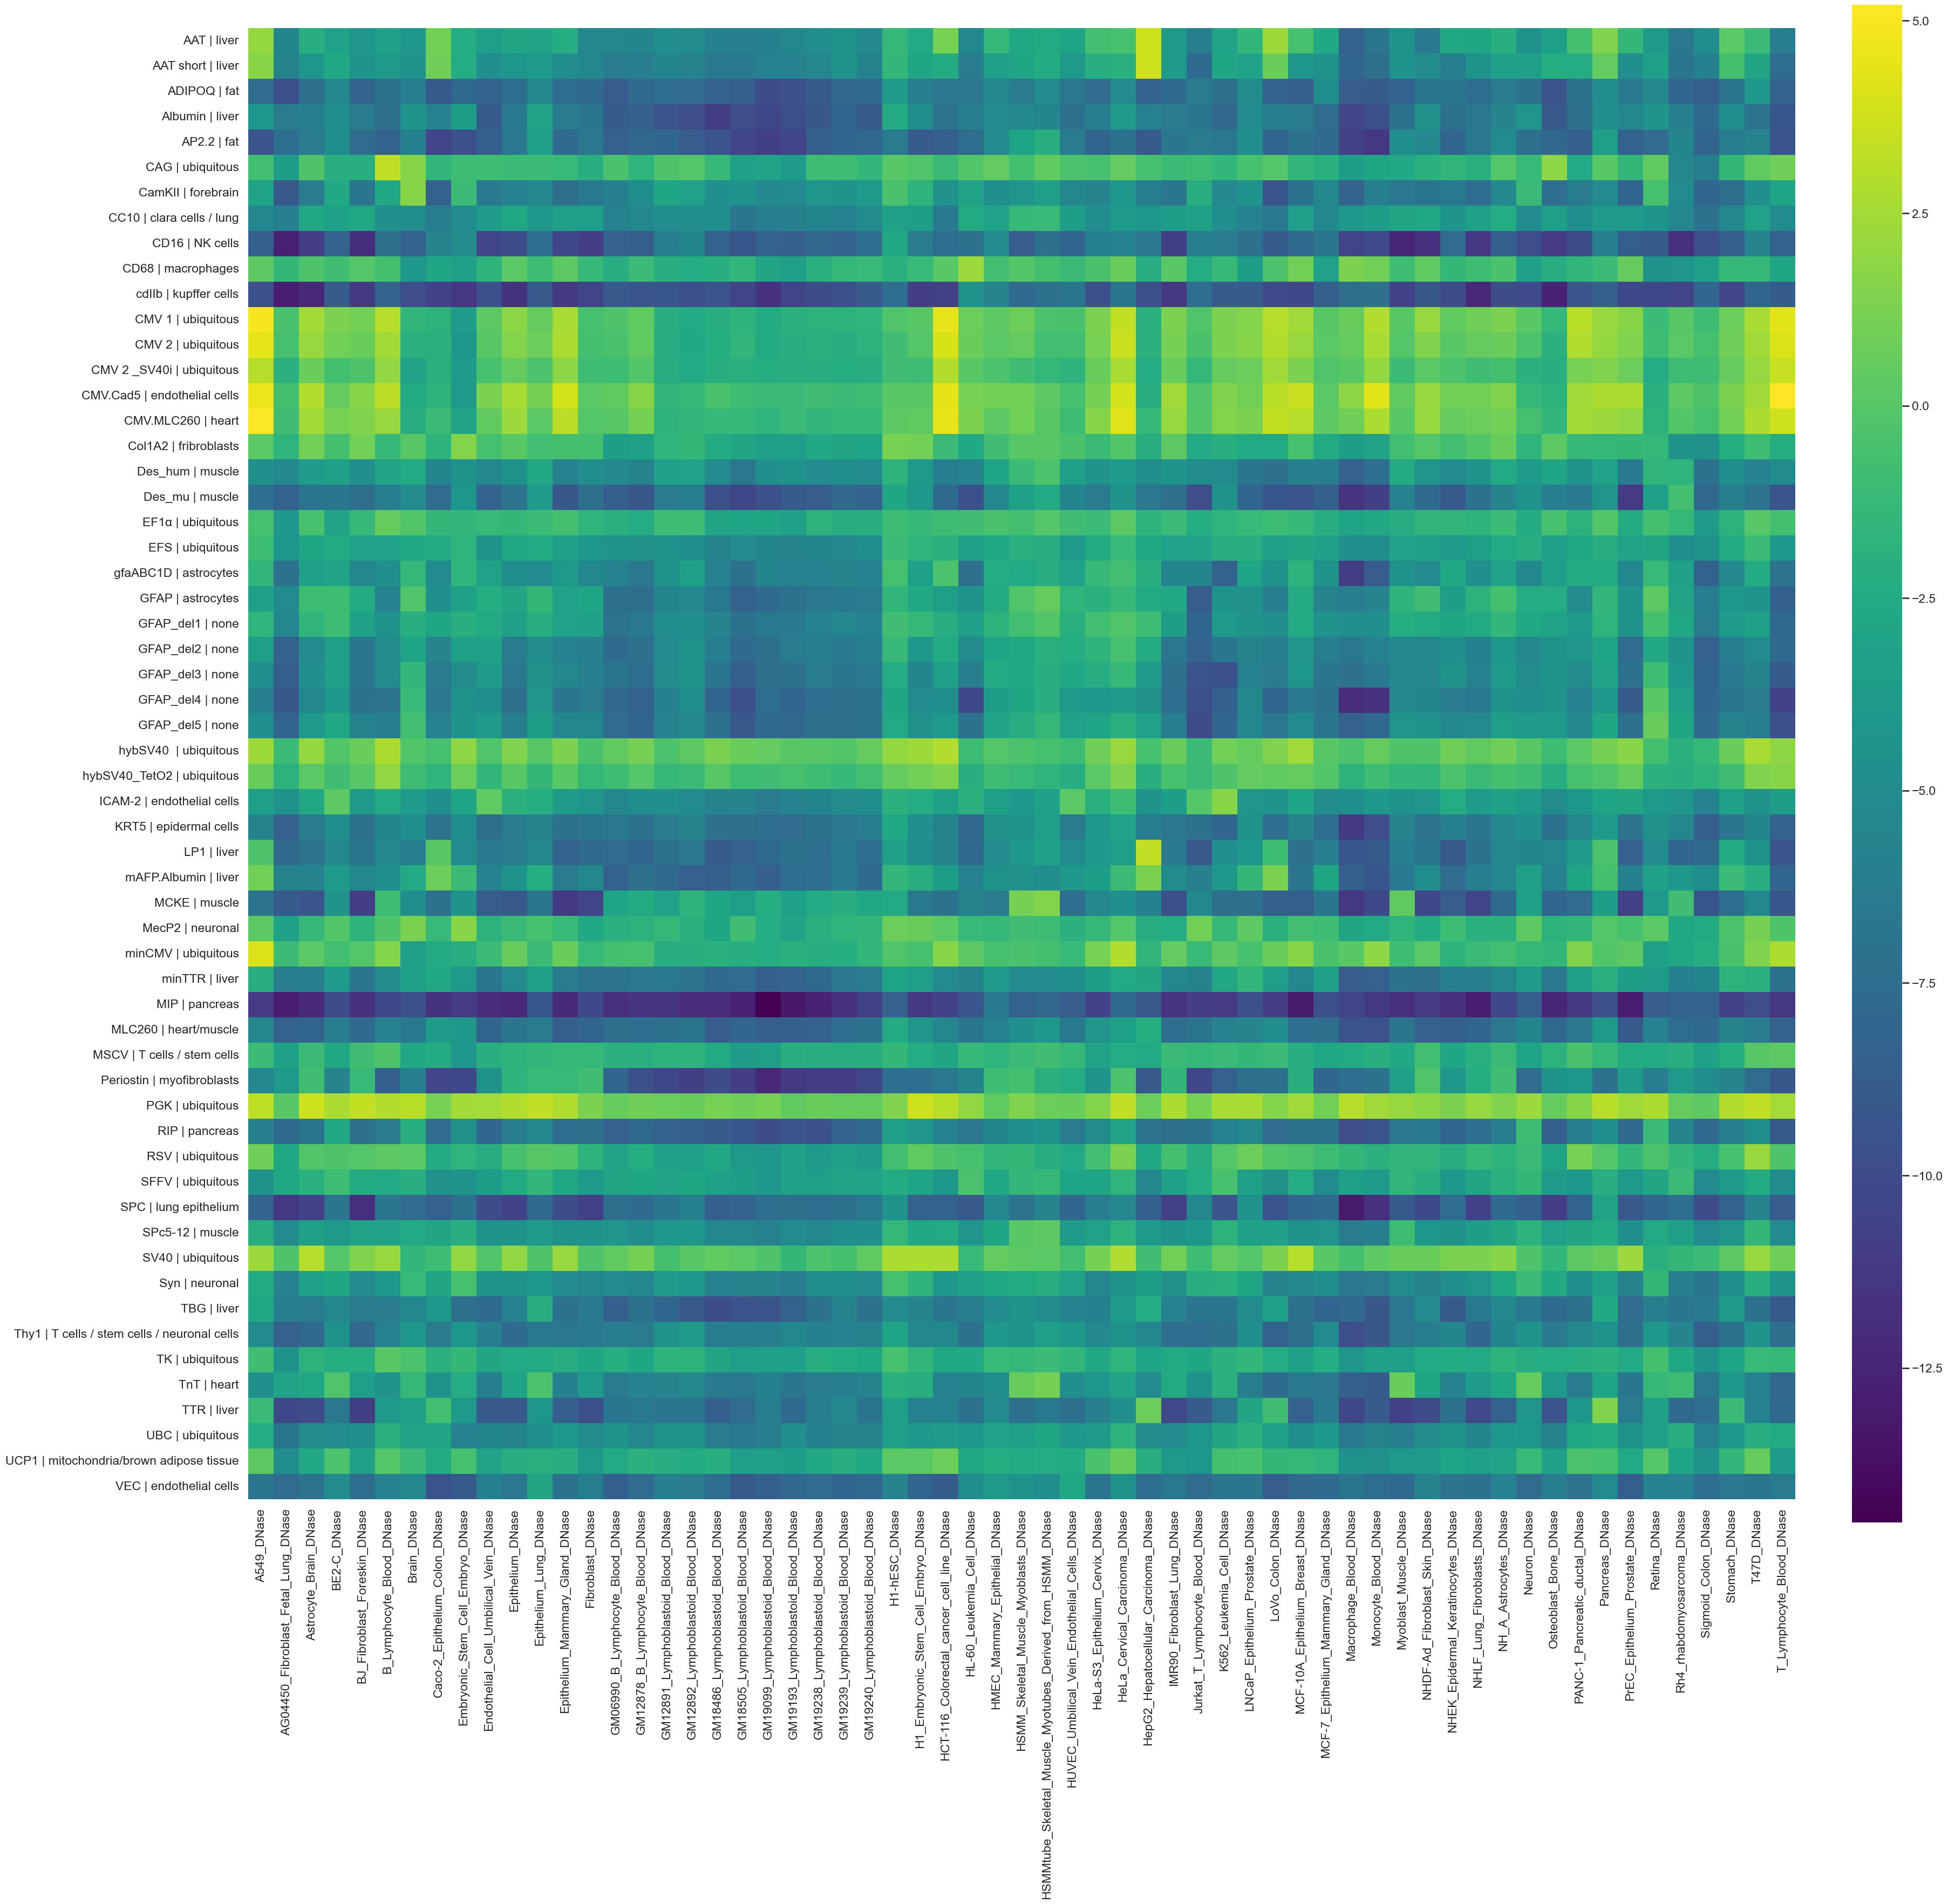

In [43]:
DNase_cols = [c for c in VEF_df.columns if c.endswith('_DNase')]


sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)


ax = sns.heatmap(
    VEF_df[DNase_cols],
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)

# ytick 偏移 0.5 以与方块中心对齐
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()
plt.savefig('figures/gene_therapy_DNase.png', dpi=100)
plt.show()